# Trajectory Optimization Comparative Study

In [1]:
# python libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# pydrake imports
from pydrake.all import (
    AddUnitQuaternionConstraintOnPlant,
    AutoDiffXd,
    BasicVector,
    ConstantVectorSource,
    DiagramBuilder,
    DirectTranscription,
    DirectCollocation,
    LogVectorOutput,
    MathematicalProgram,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    Propeller,
    PropellerInfo,
    Quaternion,
    QuaternionEulerIntegrationConstraint,
    RigidTransform,
    RollPitchYaw_,
    RigidTransform_,
    RotationMatrix,
    Simulator,
    SymbolicVectorSystem,
    Solve,
    SnoptSolver,
    UnitQuaternionConstraint,
    Variable,
)

from pydrake.examples import QuadrotorPlant

from underactuated import ConfigureParser
from underactuated.scenarios import AddFloatingRpyJoint

# increase default size matplotlib figures
from matplotlib import rcParams

rcParams["figure.figsize"] = (8, 5)

## Problem Description

In this problem we'll solve for trajectories that efficiently navigate a drone from through a forest, while avoiding a random initialization of trees.
We'll make a few simplifying assumptions about the world we're in:
- the forest is 2D,
- the trees are point masses and do not move.

## Model of the 2D Universe

Let's start by setting up the quadrotor. We will make use of the QuadrotorPlant class from drake, and instantiate both a regular version and an AutoDiff version to support the operations of a Mathematical Program. We also initialize the contexts for both variants here.

In [2]:
def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant = builder.AddSystem(MultibodyPlant(0.0))
    parser = Parser(plant)
    ConfigureParser(parser)
    (model_instance,) = parser.AddModelsFromUrl(
        "package://drake/examples/quadrotor/quadrotor.urdf"
    )
    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )
    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = plant.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")

    return builder.Build(), plant

# quadrotor = QuadrotorPlant() 
# quadrotor_ad = quadrotor.ToAutoDiffXd()
# quadrotor_context = quadrotor.CreateDefaultContext()
# quadrotor_context_ad = quadrotor_ad.CreateDefaultContext()
quadrotor, mbp = MakeMultibodyQuadrotor()
quadrotor_ad = quadrotor.ToAutoDiffXd()
mbp_ad = mbp.ToAutoDiffXd()
quadrotor_context = quadrotor.CreateDefaultContext()
mbp_context = mbp.CreateDefaultContext()
quadrotor_context_ad = quadrotor_ad.CreateDefaultContext()
mbp_context_ad = mbp_ad.CreateDefaultContext()

In [3]:
state_dim = mbp.get_state_output_port().size()
input_dim = quadrotor.get_input_port().size()

print("state dim: ", state_dim)
print("input_dim: ", input_dim)

state dim:  12
input_dim:  4


Now it's time to code the `Tree` class and our `forest`. The `Tree` class has a parameter called `radius`, which outlines the size of the tree trunk. The variable `forest_edge_length` simply defines the size of our forest environment.

In [4]:
# 🌲🌲🌲 Forest params 🌲🌲🌲
np.random.seed(4)
forest_edge_length = 50
tree_max_size = 4
tree_buffer = 1

In [5]:
# Each tree in the problem is an instance of this class
class Tree(object):
    def __init__(
        self,
        name,  # string with the name of the tree
        color,  # color of the tree for plots
        position,  # position of the tree in the 2d forest in m
        radius,  # radius of the tree in m
    ):
        self.name = name
        self.color = color
        self.position = position
        self.radius = radius
        
def intersects_other_trees(subforest, new_tree):
    for tree in subforest:
        if np.linalg.norm(tree.position - new_tree.position) <= tree.radius + new_tree.radius + tree_buffer:
            return True
    return False

# trees with random data in random positions 🌲
# n_trees = 60
n_trees = 0
forest = []
for i in range(n_trees):
    tree_from_zero = np.random.uniform(size=2) * forest_edge_length
    new_tree = Tree(f"Tree_{i}", "green", tree_from_zero, np.random.random()*tree_max_size)
    while intersects_other_trees(forest, new_tree):
        tree_from_zero = np.random.uniform(size=2) * forest_edge_length
        new_tree = Tree(f"Tree_{i}", "green", tree_from_zero, np.random.random()*tree_max_size)
    forest.append(new_tree)

# for i in range(n_trees):
#     tree_from_zero = np.random.uniform(size=2) * forest_edge_length
#     forest.append(Tree(f"Tree_{i}", 
#                         "green", 
#                         tree_from_zero, 
#                         np.random.random))
    

Now we put all the pieces together in our 2D universe. The class `Universe` also implements some utility functions that will be helpful when setting up the optimization problem. For example, the `quadrotor_discrete_dynamics` function will be relevant for our `direct_shooting` implementation.

In [6]:
# UNIVERSE CLASS 🌌
# contains the quadrotor and forest (collection of Tree objs) 
# implements utility functions needed to write the trajopt
class Universe(object):
    def __init__(
        self,
        quadrotor, # quadrotor instance
        forest,  # list of instances of Tree objects
        start, # quadrotor initial state
        end # quadrotor final state
    ):
        # store data
        self.quadrotor = quadrotor
        self.forest = forest
        self.start = start
        self.end = end

    # given the tree name, returns the Tree instance
    def get_tree(self, name):
        # loop through the trees in the universe
        for tree in self.forest:
            if tree.name == name:
                return tree

        # in case tree has the given name
        print(name + " is not in the Universe!")

    # computes 2D distance vector between the quadrotor and a tree,
    def position_wrt_tree(self, state, name):
        tree = self.get_tree(name)
        pos = state[:2] - tree.position
        
        return pos

    # implement discrete dynamics
    def quadrotor_discrete_dynamics(self, state_t, input_vector, time_interval):

        # get the right instance of plant and context
        mbp_plant = (mbp_ad if isinstance(input_vector[0], AutoDiffXd) else mbp)
        mbp_plant_context = (mbp_context_ad if isinstance(input_vector[0], AutoDiffXd) else mbp_context)
        quadrotor_plant = (quadrotor_ad if isinstance(input_vector[0], AutoDiffXd) else quadrotor)
        quadrotor_plant_context = (quadrotor_context_ad if isinstance(input_vector[0], AutoDiffXd) else quadrotor_context)

        # set the state and input vectors
        # mbp_plant_context.SetContinuousState(state_t) # if using generalized forces
        quadrotor_plant_context.SetContinuousState(state_t) # if using propellor inputs
        quadrotor_plant.get_input_port().FixValue(quadrotor_plant_context, input_vector) # if using propellor inputs

        # implicit-Euler state update
        # state_t_dot = mbp_plant.EvalTimeDerivatives(mbp_plant_context) #if using generalized forces
        state_t_dot = quadrotor_plant.EvalTimeDerivatives(quadrotor_plant_context) # if using propellor inputs

        return state_t + time_interval * state_t_dot.CopyToVector()


# state - x, y, z, phi, theta, psi, x_dot, y_dot, z_dot phi_dot, theta_dot, psi_dot
start = np.array([5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
end = np.array([30, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
forest = forest
universe = Universe(quadrotor, forest, start, end)

## Plot Functions

Here are some plot functions that will help us visualizing the results. There's functionality for plotting the forest, the quadrotor trajectory, and the input trajectory.

In [7]:
# plots a circle centered at a given point with a given radius
def plot_circle(center, radius, *args, **kwargs):
    # discretize angle
    angle = np.linspace(0, 2 * np.pi)

    # plot circle
    plt.plot(
        center[0] + radius * np.cos(angle),
        center[1] + radius * np.sin(angle),
        *args,
        **kwargs
    )

def plot_forest(universe):
    ax = plt.gca()
    ax.set_xlim([0, forest_edge_length])
    ax.set_ylim([0, forest_edge_length])
    ax.set_aspect('equal')
    plt.grid(True)

    # plot Trees
    for tree in universe.forest:
        circle = plt.Circle(tree.position, tree.radius, color=tree.color, alpha = 0.5)
        ax.add_patch(circle)

        circle_buffer = plt.Circle(tree.position, tree.radius + tree_buffer, color="blue", alpha = 0.1)
        ax.add_patch(circle_buffer)
        # plt.text(*tree.position, tree.name)

    start = plt.Circle(universe.start[:2], 0.5, color="blue") 
    stop = plt.Circle(universe.end[:2], 0.5, color="red") 
    plt.text(*universe.start[:2], "start")
    plt.text(*universe.end[:2], "stop")
    ax.add_patch(start)
    ax.add_patch(stop)

# draw the 2D trajectory of the quadrotor with trees
def plot_state_trajectory(universe, trajectory):
    # plot quadrotor trajectory
    # plt.plot(
    #     trajectory[0], trajectory[1], color="k", label="Quadrotor trajectory"
    # )
    plt.scatter(trajectory[0], trajectory[1], color="k", s=1, label="Quadrotor trajectory")
    plt.scatter(trajectory[0, 0], trajectory[1, 0], color="k")

    # plot forest
    plot_forest(universe)

    # misc settings
    plt.xlabel("Meters [m]")
    plt.ylabel("Meters [m]")
    plt.grid(True)
    plt.gca().set_aspect("equal")

    # legend
    n_legend = len(plt.gca().get_legend_handles_labels()[0])
    plt.legend(
        loc="upper center",
        ncol=int(n_legend / 2),
        bbox_to_anchor=(0.5, 1.25),
        fancybox=True,
        shadow=True,
    )


# function that plots the norm of the quadrotor inputs and
# velocity normalized on their maximum value
# TODO: look into using this function (ex. plot_rocket_limits(rocket, thrust_opt, state_opt)) -- see og orbital_transfer nb for more detail
def plot_quadrotor_limits(quadrotor, thrust, state):
    # reconstruct time vector
    time_steps = thrust.shape[0]
    time = np.linspace(0, time_steps, time_steps + 1)

    # plot maximum norm limit
    plt.plot(time, np.ones(time_steps + 1), "r--", label="Limit")

    # plot normalized thrust
    thrust_norm = [np.linalg.norm(t) / quadrotor.thrust_limit for t in thrust]
    plt.step(
        time, [thrust_norm[0]] + thrust_norm, label="Thrust / thrust limit"
    )

    # plot normalized velocity
    velocity_norm = [
        np.linalg.norm(v) / quadrotor.velocity_limit for v in state[:, 2:]
    ]
    plt.plot(time, velocity_norm, label="Velocity / velocity limit")

    # plot limits
    plt.xlim(0, time_steps)
    ymax = max(1, max(thrust_norm), max(velocity_norm)) * 1.05
    plt.ylim(0, ymax)

    # misc settings
    plt.xlabel("Time step")
    plt.grid(True)
    plt.legend()

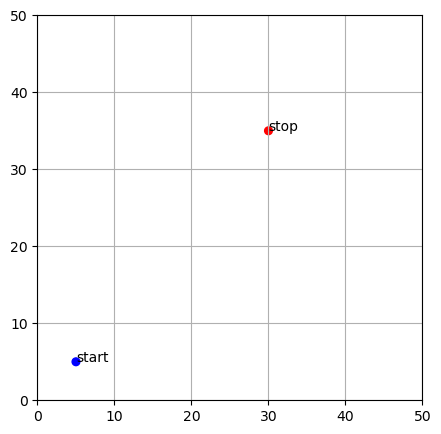

In [8]:
# plot environment
plt.figure()
plot_forest(universe)

In [9]:
def deviation_from_optimal(traj):
    """
    traj: trajectory of 6 states
    start: overall start
    end: overall end goal
    """
    optimal_dist = np.linalg.norm(traj[0:3, -1]-traj[0:3, 0])

    trial_dist_xy = 0
    for i in range(traj.shape[1]-1):
        trial_start = traj[0:2, i]
        trial_end = traj[0:2, i+1]
        trial_dist_xy += np.linalg.norm(trial_end-trial_start)

    trial_dist_xyz = 0
    for i in range(traj.shape[1]-1):
        trial_start = traj[0:3, i]
        trial_end = traj[0:3, i+1]
        trial_dist_xyz += np.linalg.norm(trial_end-trial_start)
    
    return optimal_dist, trial_dist_xy, trial_dist_xyz

##  Direct Transcription + Direct Collocation

Here we will implement two mathematical programs to compute a trajectory and control input series for the given universe instance. We implement Direct Transcription and Direct Collocation. First, we implement an "offline" version of the two, where the drone knows the location of all the trees in the environment

In [10]:
# states - x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, phi_dot, theta_dot, psi_dot
def add_constraints(prog, subuniverse, trajopt):
    # setting the initial and final state
    constraint_start = prog.AddBoundingBoxConstraint(subuniverse.start, subuniverse.start, trajopt.initial_state())
    constraint_start.evaluator().set_description("initial_state_constraint")
    # TODO: test considering matching subset of states instead of all states
    constraint_end = prog.AddBoundingBoxConstraint(subuniverse.end, subuniverse.end, trajopt.final_state())
    constraint_end.evaluator().set_description("final_state_constraint")

    # stay above zero
    constraint_floor = trajopt.AddConstraintToAllKnotPoints(trajopt.state()[2] >= 0)
    for j, constraint in enumerate(constraint_floor):
        constraint.evaluator().set_description(f"floor_constraint_{j}")

    # stay away from trees
    for tree in subuniverse.forest:
        constraint_tree = trajopt.AddConstraintToAllKnotPoints(np.linalg.norm(trajopt.state()[0:2]-tree.position) >= tree.radius)# + tree_buffer)
        for j, constraint in enumerate(constraint_tree):
            constraint.evaluator().set_description(f"{tree.name}_constraint_{j}")

def add_cost(trajopt):
    # actuation cost
    actuation_cost = trajopt.AddRunningCost(((trajopt.input()[0]) ** 2 + 
                        (trajopt.input()[1]) ** 2 + 
                        (trajopt.input()[2]) ** 2 + 
                        (trajopt.input()[3]) ** 2))

def set_initial_guess(trajopt, subuniverse, N, time_step):
    # set initial guess for trajectory
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0, N*time_step], np.vstack([subuniverse.start, subuniverse.end]).T)
    trajopt.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

def direct_transcription(subuniverse, N, time_step):
    dirtran = DirectTranscription(quadrotor, quadrotor_context, N, 
                                  DirectTranscription.TimeStep(time_step),
                                  quadrotor.get_input_port().get_index())
    prog = dirtran.prog()
    set_initial_guess(dirtran, subuniverse, N, time_step)
    add_constraints(prog, subuniverse, dirtran)
    add_cost(dirtran)
    

    # solve program
    result = Solve(prog) 
    if result.is_success():
        x_sol = dirtran.ReconstructStateTrajectory(result)
        u_sol = dirtran.ReconstructInputTrajectory(result)

        verbose = False
        if verbose:
            print(f"x_sol: {x_sol.vector_values(x_sol.get_segment_times())}")
            print(f"u_sol: {u_sol.vector_values(u_sol.get_segment_times())}")
        return True, x_sol.vector_values(x_sol.get_segment_times()), u_sol.vector_values(u_sol.get_segment_times())
    else:
        print(f"Optimization Failed\nOptimization status: {result.get_solution_result()}")
        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"Constraint name: {c.evaluator().get_description()}")
            print(f"Infeasible constraint: {c}")
        x_stuck = result.GetSolution()[:state_dim*N].reshape(N, state_dim).T[:state_dim*N].reshape(N, state_dim).T
        print("x_stuck:", x_stuck)
        return False, x_stuck, None

def direct_collocation(subuniverse, N, time_step, min_time_step, max_time_step):
    dircol = DirectCollocation(quadrotor, quadrotor_context, N, min_time_step,
                               max_time_step, quadrotor.get_input_port().get_index())
    dircol.AddEqualTimeIntervalsConstraints()
    prog = dircol.prog()
    add_constraints(prog, subuniverse, dircol)
    add_cost(dircol)
    set_initial_guess(dircol, subuniverse, N, time_step)

    # solve program
    result = Solve(prog) 
    if result.is_success():
        x_trj_poly = dircol.ReconstructStateTrajectory(result)
        u_trj_poly = dircol.ReconstructInputTrajectory(result)

        ts = np.linspace(u_trj_poly.start_time(), u_trj_poly.end_time(), N)

        x_trj = x_trj_poly.vector_values(ts)
        u_trj = u_trj_poly.vector_values(ts)

        x_trj_stable = result.GetSolution()[:state_dim*N].reshape(N, state_dim).T
        # u_trj_stable = result.GetSolution()[state_dim*N:-1].reshape(N, input_dim).T

        return True, x_trj_stable, u_trj
    else:
        print(f"Optimization Failed\nOptimization status: {result.get_solution_result()}")
        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"Constraint name: {c.evaluator().get_description()}")
            print(f"Infeasible constraint: {c}")
            
        x_stuck = result.GetSolution()[:state_dim*N].reshape(N, state_dim).T[:state_dim*N].reshape(N, state_dim).T

        # x_trj_poly = dircol.ReconstructStateTrajectory(result)
        # u_trj_poly = dircol.ReconstructInputTrajectory(result)

        # ts = np.linspace(u_trj_poly.start_time(), u_trj_poly.end_time(), N)
        # x_trj = x_trj_poly.vector_values(ts)
        # u_trj = u_trj_poly.vector_values(ts)

        # print("x_stuck:", x_stuck)
        return False, x_stuck
        # return False, x_trj, u_trj

In [11]:
N = 50
time_step = 0.2
min_time_step = 0.01
max_time_step = 0.5

Deviation from optimal: (38.948363230388686, 38.94836565989581, 38.94837013032934)


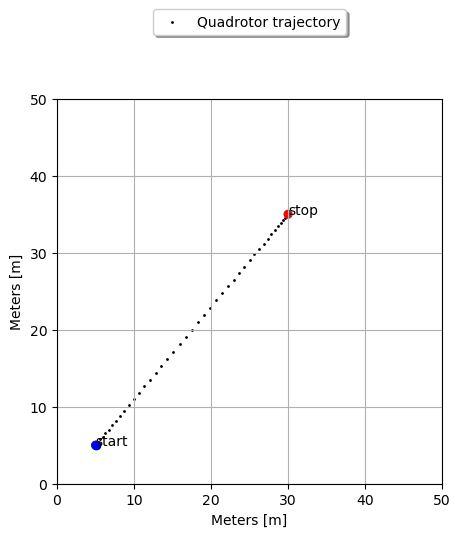

In [12]:
# DIRECT TRANSCRIPTION -- OFFLINE
status, x_trj_dirtran_offline, u_trj_dirtran_offline = direct_transcription(universe, N, time_step)
print(f"Deviation from optimal: {deviation_from_optimal(x_trj_dirtran_offline)}")
plot_state_trajectory(universe, x_trj_dirtran_offline)

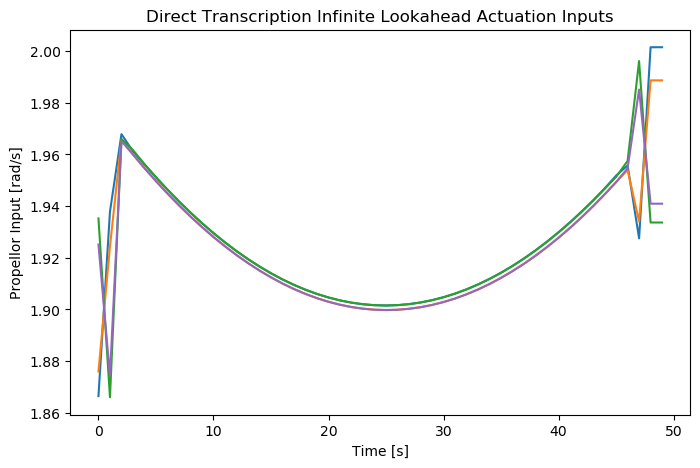

In [13]:
x = np.arange(u_trj_dirtran_offline.shape[1])
fig = plt.figure()
plt.title("Direct Transcription Infinite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Propellor Input [rad/s]")
plt.plot(x,u_trj_dirtran_offline[0],'tab:blue',x,u_trj_dirtran_offline[1],'tab:orange',x,u_trj_dirtran_offline[2],'tab:green',x,u_trj_dirtran_offline[3],'tab:purple')

In [14]:
# DIRECT COLLOCATION -- OFFLINE
status, x_trj_dircol_offline, u_trj_dircol_offline = direct_collocation(universe, N, time_step, min_time_step, max_time_step)
print(f"Deviation from optimal: {deviation_from_optimal(x_trj_dircol_offline)}")
plot_state_trajectory(universe, x_trj_dircol_offline)

KeyboardInterrupt: 

In [ ]:
x = np.arange(u_trj_dircol_offline.shape[1])
fig = plt.figure()
plt.title("Direct Collocation Infinite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Propellor Input [rad/s]")
plt.plot(x,u_trj_dircol_offline[0],'tab:blue',x,u_trj_dircol_offline[1],'tab:orange',x,u_trj_dircol_offline[2],'tab:green',x,u_trj_dircol_offline[3],'tab:purple')

##  Direct Transcription + Direct Collocation Horizon Based

Here we reformuulate the the Direct Transcription and Direct Shooting problems to be iterative. Essentially, the drone only has a limited view of the forest, defined by the variable `horizon_radius`. The drone will iteratively execute Direct Transcription or Direct Collocation within its horizon, planning towards a `subgoal` for each iteration. It continues this process until it reaches the final goal.

In [ ]:
def get_subgoal(subuniverse, current_state, goal, horizon_radius):
    """
    Deterimines an intermediate goal for the drone to plan towards
    given the global end and the subuniverse
    """
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(2)  # local end of the subuniverse
    for j, tree in enumerate(subuniverse.forest):
        constraint = prog.AddConstraint(np.sum((x - tree.position)**2) >= (tree.radius)**2) # make local end isn't in a tree + tree_buffer)**2)
        constraint.evaluator().set_description(f"tree_constraint_{j}")
    in_horizon_constraint = prog.AddConstraint(np.sum((x - current_state[0:2])**2) <= horizon_radius**2) # local end within horizon
    in_horizon_constraint.evaluator().set_description("subgoal_in_horizon_constraint")
    distance = x - goal[0:2]
    prog.AddCost(distance[0]**2 + distance[1]**2)
    prog.SetInitialGuess(x, current_state[0:2])
    result = Solve(prog)
    return result.GetSolution(x)

def get_subuniverse(universe, current_state, horizon_radius):
    """
    Determines which trees are within the field of view of the drone
    and creates a subuniverse containing only those trees
    """
    subforest = []
    for tree in universe.forest:
        if np.linalg.norm(current_state[0:2] - tree.position) - (tree.radius) <= horizon_radius: # + tree_buffer in tree.radius paren
            subforest.append(tree)
    subuniverse = Universe(quadrotor, subforest, current_state, None)
    return subuniverse

In [ ]:
def finite_horizon(traj_opt_method):
    # traj_opt_method: either "direct_transcription" or "direct_collocation"
    horizon_radius = 5
    at_goal = False
    N = 10
    time_step = 0.2
    min_time_step = 0.01
    max_time_step = 0.5
    full_trajectory = np.zeros((state_dim, 0))
    full_inputs = np.zeros((input_dim, 0))

    current_state = start
    while not at_goal:
        # get the subuniverse - the section of the universe the drone can see
        subuniverse = get_subuniverse(universe, current_state, horizon_radius)
        # determine where the drone should move to within the subuniverse
        subgoal = get_subgoal(subuniverse, current_state, end, horizon_radius)
        subgoal = np.concatenate((subgoal, np.zeros(10))) 
        # set the goal in the subuniverse
        subuniverse.end = subgoal
        print(f"New subgoal: {subgoal}")

        # get the partial trajectory for state and input
        if traj_opt_method == "direct_transcription":
            status, x_trajectory, u_trajectory = direct_transcription(subuniverse, N, time_step)
        if traj_opt_method == "direct_collocation":
            status, x_trajectory, u_trajectory = direct_collocation(subuniverse, N, time_step, min_time_step, max_time_step)
        
        if not status:
            break

        # add into the whole trajectory
        full_trajectory = np.hstack((full_trajectory, x_trajectory))

        # extract both state and input for continuous gradients upon next iteration
        last_state = x_trajectory[:, -1]

        full_inputs = np.hstack((full_inputs, u_trajectory))
        last_input = u_trajectory[:, -1]

        # if we made it to the goal, we are done
        if np.linalg.norm(last_state[:3] - end[:3]) < 0.1:
            at_goal = True
        
        current_state = last_state
    
    return full_trajectory, full_inputs

In [ ]:
# DIRECT TRANSCRIPTION -- HORIZON
dirtran_horizon_trajectory, dirtran_horizon_input = finite_horizon("direct_transcription")
# dirtran_horizon_trajectory = finite_horizon("direct_transcription")

print(f"Deviation from optimal: {deviation_from_optimal(dirtran_horizon_trajectory)}")
plot_state_trajectory(universe, dirtran_horizon_trajectory[:,:])


In [ ]:
print(dirtran_horizon_input.shape)
x = np.arange(dirtran_horizon_input.shape[1])*time_step
fig = plt.figure()
plt.title("Direct Transcription Finite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Propellor Input [rad/s]")
plt.plot(x,dirtran_horizon_input[0],'tab:blue',x,dirtran_horizon_input[1],'tab:orange',x,dirtran_horizon_input[2],'tab:green',x,dirtran_horizon_input[3],'tab:purple')

In [ ]:
# # DIRECT COLLOCATION -- HORIZON
dircol_horizon_trajectory, dircol_horizon_input = finite_horizon("direct_collocation")
print(f"Deviation from optimal: {deviation_from_optimal(dircol_horizon_trajectory)}")
plot_state_trajectory(universe, dircol_horizon_trajectory)

In [ ]:
x = np.arange(dircol_horizon_input.shape[1])*time_step
fig = plt.figure()
plt.title("Direct Collocation Finite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Propellor Input [rad/s]")
plt.plot(x,dircol_horizon_input[0],'tab:blue',x,dircol_horizon_input[1],'tab:orange',x,dircol_horizon_input[2],'tab:green',x,dircol_horizon_input[3],'tab:purple')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# status, x_trj_dirtran_offline, u_trj_dirtran_offline = direct_transcription(universe, N, time_step)
# print(full_trajectory.shape)
traj = x_trj_dirtran_offline
print(traj.shape)
plt_color = 'maroon'
for i in range(traj.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.95)
    x = traj[0,i]
    y = traj[1,i]
    z = traj[2,i]
    ax.scatter(x, y, z, marker='o', color = plt_color)

x = traj[0,:]
y = traj[1,:]
z = traj[2,:]
ax.plot(x,y,z, color='maroon')


# for tree in universe.forest:
#     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

# Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
# ax.plot_surface(Xc, Yc, Zc, alpha=0.5, color='g')

ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_zlabel('z position [m]')
ax.set_title('Direct Transcription Position')

for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

traj = x_trj_dircol_offline
print(traj.shape)
plt_color = 'b'
for i in range(traj.shape[-1]):
    plt_color = lighten_color(plt_color, amount=0.95)
    x = traj[0,i]
    y = traj[1,i]
    z = traj[2,i]
    ax.scatter(x, y, z, marker='o', color = plt_color)

x = traj[0,:]
y = traj[1,:]
z = traj[2,:]
ax.plot(x,y,z, color='b')


for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

traj = dirtran_horizon_trajectory
print(traj.shape)
plt_color = 'b'
for i in range(traj.shape[-1]):
    plt_color = lighten_color(plt_color, amount=0.95)
    x = traj[0,i]
    y = traj[1,i]
    z = traj[2,i]
    ax.scatter(x, y, z, marker='o', color = plt_color)

x = traj[0,:]
y = traj[1,:]
z = traj[2,:]
ax.plot(x,y,z, color='b')


for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

traj = dircol_horizon_trajectory
print(traj.shape)
plt_color = 'b'
for i in range(traj.shape[-1]):
    plt_color = lighten_color(plt_color, amount=0.95)
    x = traj[0,i]
    y = traj[1,i]
    z = traj[2,i]
    ax.scatter(x, y, z, marker='o', color = plt_color)

x = traj[0,:]
y = traj[1,:]
z = traj[2,:]
ax.plot(x,y,z, color='b')


for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

traj1 = dircol_horizon_trajectory
traj2 = dirtran_horizon_trajectory

plt_color = 'midnightblue'
for i in range(traj1.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.98)
    x1 = traj1[0,i]
    y1 = traj1[1,i]
    z1 = traj1[2,i]
    ax.scatter(x1, y1, z1, marker='o', color = plt_color)

x1 = traj1[0,:]
y1 = traj1[1,:]
z1 = traj1[2,:]
ax.plot(x1,y1,z1, color='midnightblue', label = "direct collocation finite lookahead")

plt_color = 'maroon'
for i in range(traj2.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.95)
    x2 = traj2[0,i]
    y2 = traj2[1,i]
    z2 = traj2[2,i]
    ax.scatter(x2, y2, z2, marker='o', color = plt_color)

x2 = traj2[0,:]
y2 = traj2[1,:]
z2 = traj2[2,:]
ax.plot(x2,y2,z2, color='maroon', label = "direct transcription finite lookahead")

ax.legend()

ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_zlabel('z position [m]')




for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

traj1 = x_trj_dircol_offline
traj2 = x_trj_dirtran_offline

plt_color = 'midnightblue'
for i in range(traj1.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.98)
    x1 = traj1[0,i]
    y1 = traj1[1,i]
    z1 = traj1[2,i]
    ax.scatter(x1, y1, z1, marker='o', color = plt_color)

x1 = traj1[0,:]
y1 = traj1[1,:]
z1 = traj1[2,:]
ax.plot(x1,y1,z1, color='midnightblue', label = "direct collocation infinite lookahead")

plt_color = 'maroon'
for i in range(traj2.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.95)
    x2 = traj2[0,i]
    y2 = traj2[1,i]
    z2 = traj2[2,i]
    ax.scatter(x2, y2, z2, marker='o', color = plt_color)

x2 = traj2[0,:]
y2 = traj2[1,:]
z2 = traj2[2,:]
ax.plot(x2,y2,z2, color='maroon', label = "direct transcription infinite lookahead")

ax.legend()

ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_zlabel('z position [m]')



for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [ ]:
2000*(-1*np.arctan(2000*(dist_from_tree - tree.radius)) + np.pi/2)

In [0]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

In [0]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.DataFrame(dict(
    x = traj[0,:],
    y = traj[1,:], 
    z = traj[2,:],
    s = 0.1*np.ones(traj.shape[1])
))

fig1 = px.scatter_3d(df, x='x', y='y', z='z',size='s')
fig2 = px.line_3d(df, x='x', y='y', z='z')

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

In [0]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.DataFrame(dict(
    x = x_trj_dircol_offline[0,:],
    y = x_trj_dircol_offline[1,:], 
    z = x_trj_dircol_offline[2,:],
    s = 0.1*np.ones(x_trj_dircol_offline.shape[1])
))

fig1 = px.scatter_3d(df, x='x', y='y', z='z', size = 's')
fig2 = px.line_3d(df, x='x', y='y', z='z')

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

In [0]:
# from mpl_toolkits.mplot3d import Axes3D 

# # https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
# def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
#     z = np.linspace(-0.0175, 0, 50)
#     theta = np.linspace(0, 2*np.pi, 50)
#     theta_grid, z_grid=np.meshgrid(theta, z)
#     x_grid = radius*np.cos(theta_grid) + center_x
#     y_grid = radius*np.sin(theta_grid) + center_y
#     return x_grid,y_grid,z_grid

# # https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
# def lighten_color(color, amount=0.5):
#     """
#     Lightens the given color by multiplying (1-luminosity) by the given amount.
#     Input can be matplotlib color string, hex string, or RGB tuple.

#     Examples:
#     >> lighten_color('g', 0.3)
#     >> lighten_color('#F034A3', 0.6)
#     >> lighten_color((.3,.55,.1), 0.5)
#     """
#     import matplotlib.colors as mc
#     import colorsys
#     try:
#         c = mc.cnames[color]
#     except:
#         c = color
#     c = colorsys.rgb_to_hls(*mc.to_rgb(c))
#     return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


# universe.end = [5,5,0,0,0,0,0,0,0,0,0,0]

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# status, x_trj_dirtran_offline, u_trj_dirtran_offline = direct_transcription(universe, N, time_step)
# plt_color = 'b'
# for i in range(x_trj_dirtran_offline.shape[-1]):
#     plt_color = lighten_color(plt_color, amount=0.95)
#     x = x_trj_dirtran_offline[0,i]
#     y = x_trj_dirtran_offline[1,i]
#     z = x_trj_dirtran_offline[2,i]
#     ax.scatter(x, y, z, marker='o', color = plt_color)

# # for tree in universe.forest:
# #     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
# #     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

# Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
# ax.plot_surface(Xc, Yc, Zc, alpha=0.5, color='g')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

In [0]:
'''
Best run:
 - start @ 5,5 end @ 30, 35

strange things:
- start @ 5,5 end @ 35, 35: direct collocation ran forever and hit max iteration limit
'''

In [ ]:
'''
❓ Questions for Russ pt. 2❓
- current status: finite horizon erroring out
-- was working when setting generalized forces
-- switched to propellors --> broke finite horizon
- strange things:
-- no descriptors for constraints
'''

In [ ]:
'''
❓ Questions for Russ ❓
- current status: getting gimbal lock because of pitch in finite horizon direct collocation
- prior attempts at fixing:
-- adding constraint on pitch: did not fix because only constrains points and not intermediate states
-- adding cost on pitch: tried this and didn't fix the problem (don't really know why)

- proposed solution: use quaternion instead of RPY
-- constraints exist to enforce quaternion properties: linked in piazza post
-- we could take RPY, convert to quaterion, enforce properties
-- built in dynamics still use RPY, so error could still occur. How to handle this?
'''

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4497d15d-fb77-459c-b24d-9956564a15a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>